<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Sequence processing using RNNs** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
!pip install -r requirements.txt
!pip install tensorflow[and-cuda]

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose
tf.config.list_physical_devices('GPU')

2024-11-20 21:56:14.004682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732136174.018925   29684 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732136174.023468   29684 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 21:56:14.037850: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1732136176.905849   29684 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

[]

In [3]:
tf.__version__

'2.18.0'

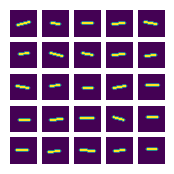

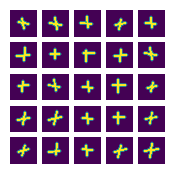

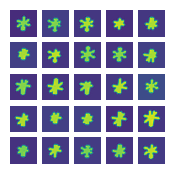

In [4]:
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images(sign='-'))
show_generated(generate_images(sign='+'))
show_generated(generate_images(sign='*'))

In [5]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #8596

X_text: "42+98" = y_text: "140"


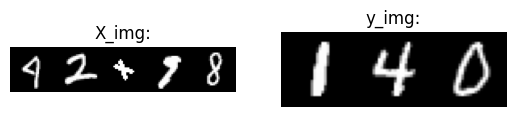

Query #417

X_text: "2-8  " = y_text: "-6 "


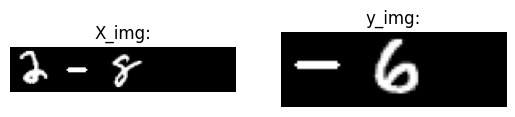

Query #5526

X_text: "27+63" = y_text: "90 "


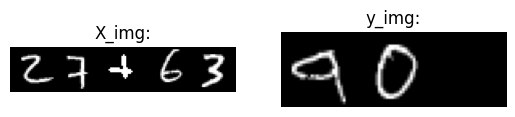

Query #7009

X_text: "35-4 " = y_text: "31 "


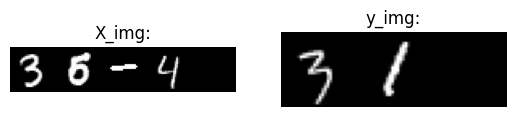

Query #878

X_text: "4+39 " = y_text: "43 "


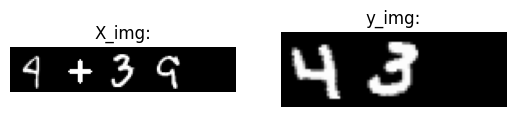

Query #3857

X_text: "19-28" = y_text: "-9 "


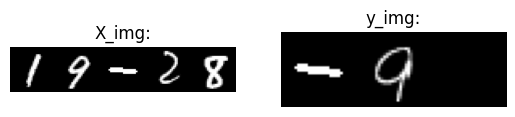

Query #5347

X_text: "26-73" = y_text: "-47"


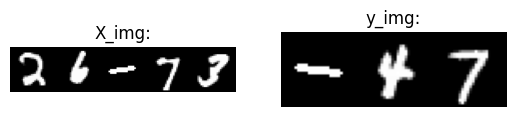

Query #6621

X_text: "33-10" = y_text: "23 "


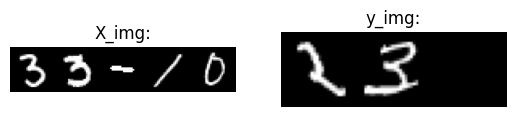

Query #9406

X_text: "47+3 " = y_text: "50 "


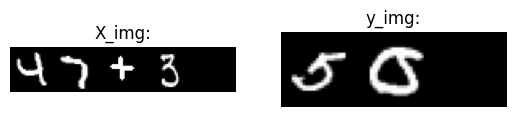

Query #3920

X_text: "19+60" = y_text: "79 "


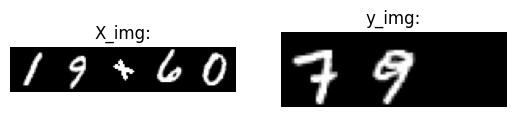

In [6]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [7]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks
def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted
# TODO set unrandom but for debug its fine
X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)
random_numbers = np.random.randint(0, len(X_text), 4)
print(X_text_onehot.shape, y_text_onehot.shape)
for i in range(4):
    print(y_text_onehot[random_numbers[i]])
    print(decode_labels(y_text_onehot[random_numbers[i]]))

(20000, 5, 13) (20000, 3, 13)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
-21
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
89 
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
160
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
-38


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [8]:
# import input layer
from tensorflow.keras.layers import Input
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(Input(shape=(max_query_length, len(unique_characters))))
    text2text.add(LSTM(256))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # text2text.summary() bart even weggehaald

    return text2text

In [9]:
model = build_text2text_model()

In [10]:
test_sizes = np.array([i*10 for i in range(1, 10)])
test_sizes

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [11]:
## Your code (look at the assignment description for your tasks for text-to-text model):
## Your first task is to fit the text2text model using X_text and y_text)
## dit is taak 1.2
validation_split = 0.1
X_val = X_text_onehot[:int(len(X_text_onehot)*validation_split)]
y_val = y_text_onehot[:int(len(y_text_onehot)*validation_split)]
X_train = X_text_onehot[int(len(X_text_onehot)*validation_split):]
y_train = y_text_onehot[int(len(y_text_onehot)*validation_split):]
best_config = None
for test_size in test_sizes[:1]:
    print(f"Test size: {test_size}, Validation split: {validation_split}, train size: {int(100-test_size)}")

    X_train_batch, X_test_batch,y_train_batch, y_test_batch = train_test_split(X_train, y_train, test_size=test_size/100, random_state=42)
    model = build_text2text_model()
    history = model.fit(X_train_batch, y_train_batch, validation_data=(X_val, y_val), epochs=10, batch_size=128)
    # history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)
    results = model.evaluate(X_test_batch, y_test_batch)
    print(f"Test loss: {results[0]}, Test accuracy: {results[1]}")
    if best_config is None or results[1] > best_config[1]:
        best_config = (test_size, results[1], results[0])


Test size: 10, Validation split: 0.1, train size: 90
Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2794 - loss: 2.2233 - val_accuracy: 0.3977 - val_loss: 1.9882
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4070 - loss: 1.6777 - val_accuracy: 0.2040 - val_loss: 3.5623
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4917 - loss: 1.4058 - val_accuracy: 0.2465 - val_loss: 3.9682
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5320 - loss: 1.2907 - val_accuracy: 0.2283 - val_loss: 4.4763
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5665 - loss: 1.2059 - val_accuracy: 0.2147 - val_loss: 4.7922
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5872 - loss: 1.1486 - val_accuracy: 0.2358 - val_loss: 5.0103
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5982 - loss: 1.1060 - val_accuracy: 0.2280 - val_loss: 5.3624
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 2

In [12]:
# X_train_batch, X_test_batch,y_train_batch, y_test_batch = train_test_split(X_train, y_train, test_size=best_config[0]/100, random_state=42)
# model = build_text2text_model()
# history = model.fit(X_train_batch, y_train_batch, validation_data=(X_val, y_val), epochs=10, batch_size=128)

In [13]:
predictions = model.predict(X_test_batch)
# put them into a readable format
for i in range(5):
    print(f"Predicted: {decode_labels(predictions[i])}, True: {decode_labels(y_test_batch[i])}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Predicted: 103, True: 109
Predicted: 90 , True: 95 
Predicted: 59 , True: 61 
Predicted: 69 , True: 65 
Predicted: 89 , True: 81 


In [14]:
def decode_all(predictions):
    decoded_predictions = []
    for i in range(len(predictions)):
        decoded_predictions.append(decode_labels(predictions[i]))
    return decoded_predictions
decoded_predictions = decode_all(predictions)
decoded_y_test = decode_all(y_test_batch)
decoded_predictions[:5], decoded_y_test[:5]

(['103', '90 ', '59 ', '69 ', '89 '], ['109', '95 ', '61 ', '65 ', '81 '])

In [15]:
def check_classification(y_pred, y_true):
  bools = [y_pred[i] == y_true[i] for i in range(len(y_pred))]
  correct = np.where(bools)[0]
  incorrect = np.where(np.logical_not(bools))[0]
  return len(correct), len(incorrect), np.array(correct), np.array(incorrect)

In [16]:
correct_num, incorrect_num, correct_indices, incorrect_indices = check_classification(decoded_predictions, decoded_y_test)
print(f"Correct: {correct_num}, Incorrect: {incorrect_num}")
print(f"accuracy: {correct_num/(correct_num+incorrect_num)}")

Correct: 120, Incorrect: 1680
accuracy: 0.06666666666666667


In [17]:
# we need to convert our strings to integers. 
# Note that due to white spacing we must first subtract any white spacing, before converting to integers. 
# Furthermore, we should note exceptions such as '- ' which is basically just a black, we should completely remove these, but do count them up. 
# These are of course completely wrong as no number is present.
import re
def process_strings(input_list):
    cleaned_list = []
    invalid_count = 0

    for item in input_list:
        cleaned_item = item.replace(" ", "")
        # # check if there is only a + or - in the string
        if re.search(r"[+-]", cleaned_item[1:]) or re.search(r"[^0-9+-]", cleaned_item) or not cleaned_item or cleaned_item == '-':
            invalid_count += 1
            continue


        cleaned_item_int = int(cleaned_item)
        cleaned_list.append(cleaned_item_int)
    return cleaned_list, invalid_count

# Example usage:
input_strings = [" 92 ", "30", "-67", "  -  20 ", "12 - 34", "49-", '']
cleaned_numbers, invalid_count = process_strings(input_strings)

print("Cleaned Numbers:", cleaned_numbers)
print("Invalid Count:", invalid_count)


Cleaned Numbers: [92, 30, -67, -20]
Invalid Count: 3


In [18]:
incorrect_indices

array([   0,    1,    2, ..., 1796, 1798, 1799])

In [19]:
cleaned_wrong_classified, invalid_count_wrong_classified = process_strings(np.array(decoded_predictions)[incorrect_indices])
cleaned_true, invalid_count_true = process_strings(y_text[incorrect_indices])
print(invalid_count_wrong_classified, invalid_count_true)


31 0


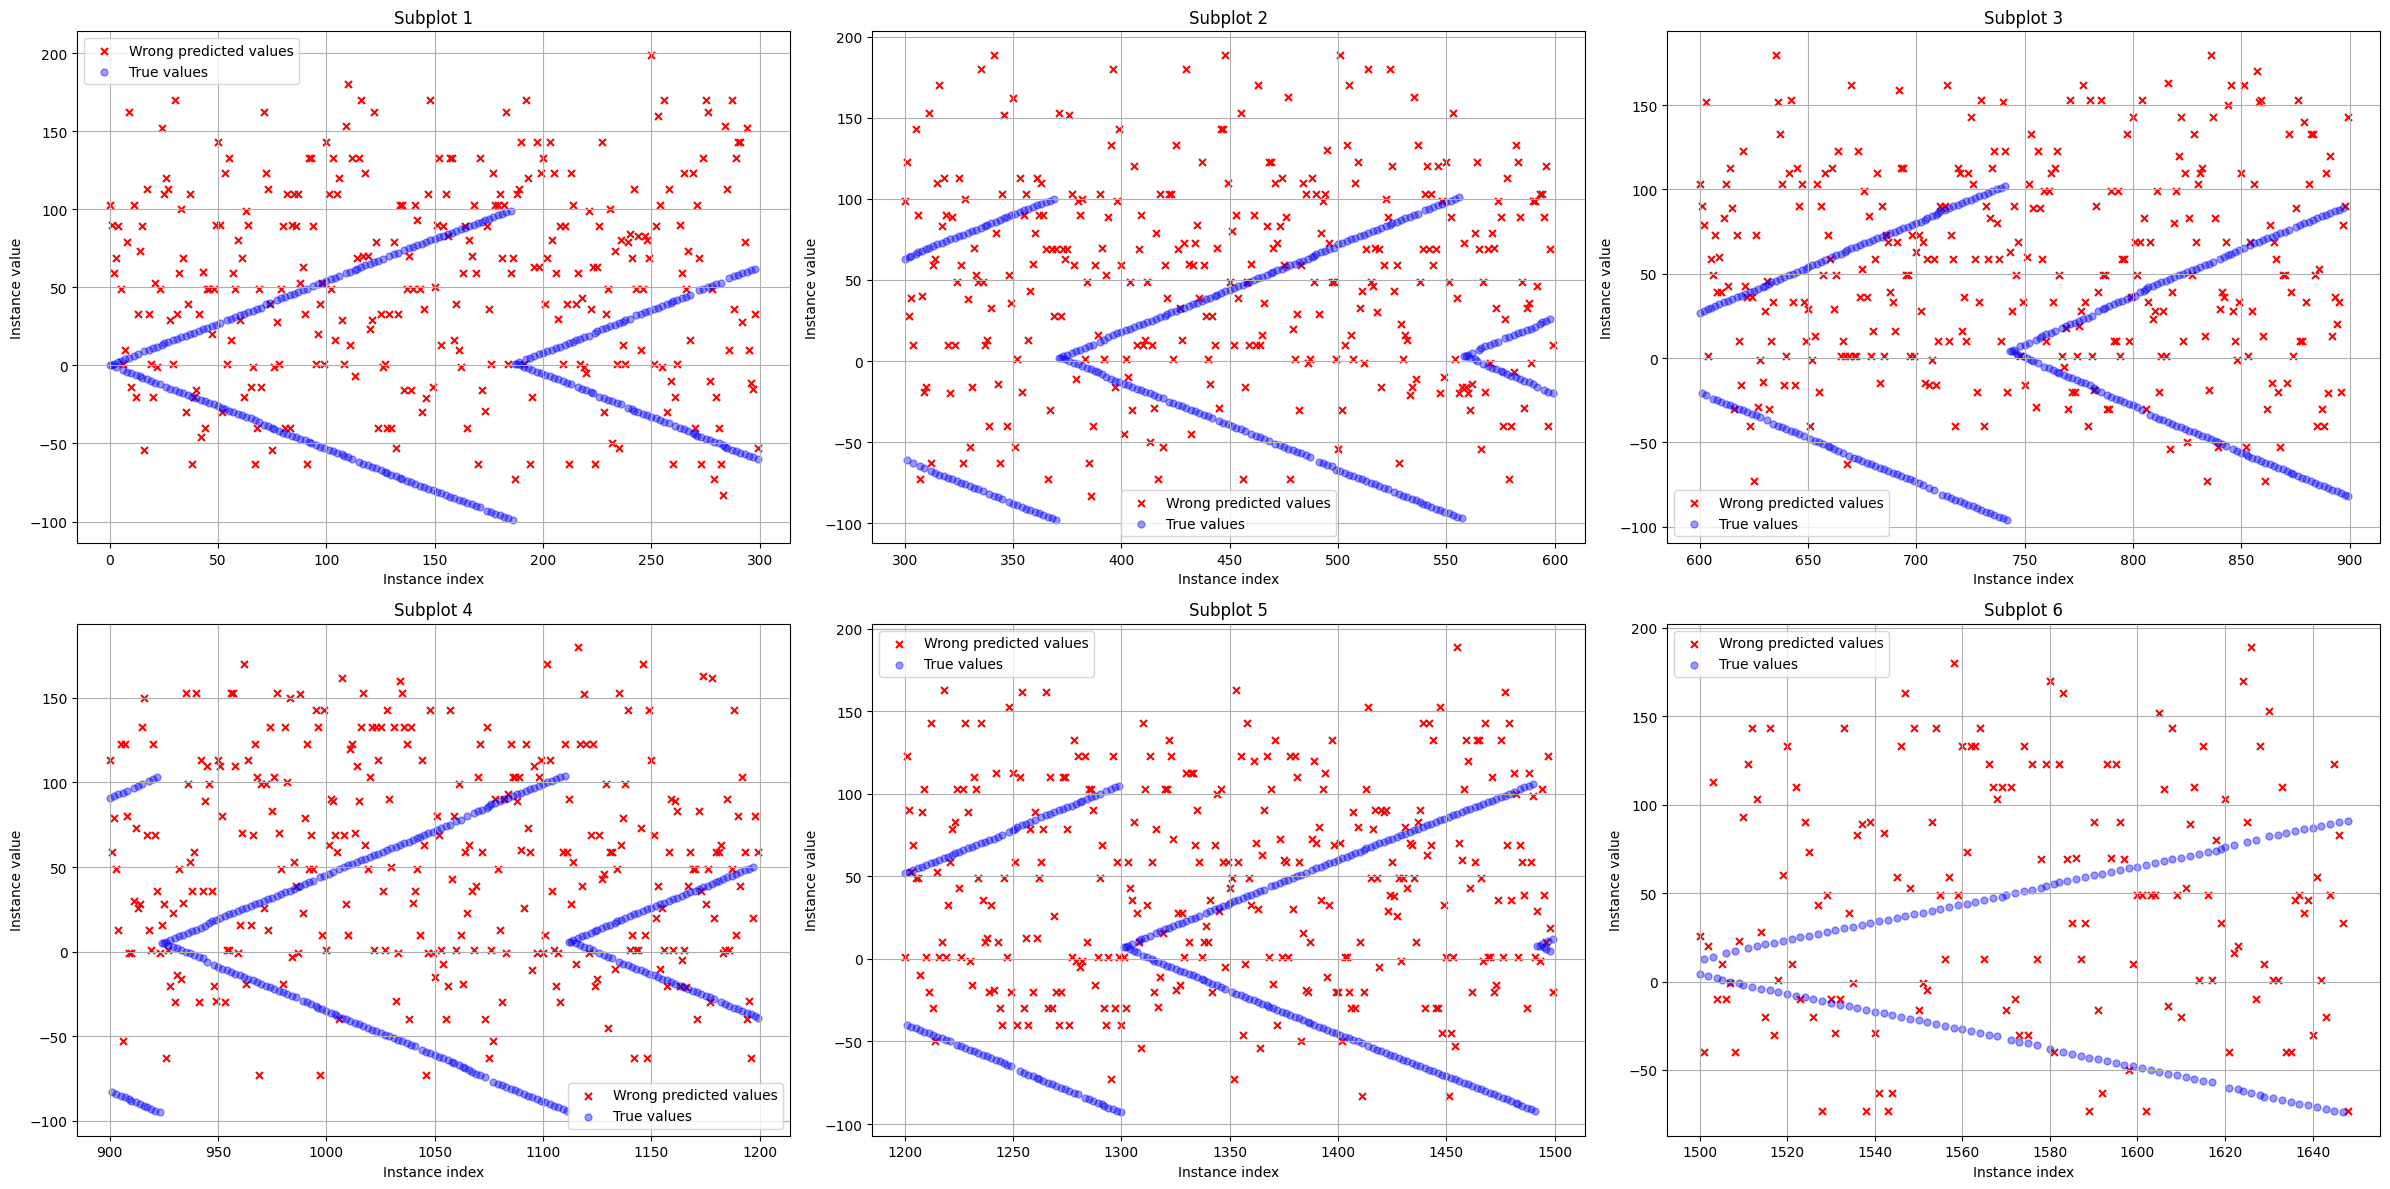

In [20]:
# visualize the wrongly classified instances (2.2)
# Set the batch size
batch_size = 300

# Get the total number of instances
total_instances = len(cleaned_wrong_classified)

# Calculate the number of subplots needed
num_subplots = int(np.ceil(total_instances / batch_size))

# Calculate the number of rows and columns for the subplot grid
num_rows = int(np.sqrt(num_subplots))
num_cols = int(np.ceil(num_subplots / num_rows))

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(24, 12))

# Flatten the axs array if it's a multi-dimensional array
axs = axs.flatten()

# Plot instances in batches of 250
for i in range(num_subplots):
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, total_instances)

    # Use the current subplot
    ax = axs[i]

    # Plot instances that were wrongly labeled
    ax.scatter(range(start_index, end_index), cleaned_wrong_classified[start_index:end_index],
               color='red', marker='x', label='Wrong predicted values', s=25)

    # Plot true values of the wrongly classified instances
    ax.scatter(range(start_index, end_index), cleaned_true[start_index:end_index],
               color='blue', marker='o', label='True values', s=25, alpha=0.4)

    # Customize the subplot
    ax.set_xlabel('Instance index')
    ax.set_ylabel('Instance value')
    ax.set_title(f'Subplot {i+1}')
    ax.grid()

    # Create a legend with unique labels
    ax.legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Display the grid of subplots
plt.show()



---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [48]:
def build_img2text_model(num_encode_layers: int = 1,num_decode_layers:int = 1,
                         learning_rate: float=0.001, max_answer_length: int=3):
    img2text = tf.keras.Sequential()
    img2text.add(Input(shape=(5, 28*28)))
    img2text.add(LSTM(400,return_sequences=False))
    img2text.add(RepeatVector(max_answer_length))
    img2text.add(LSTM(400, return_sequences=True))

    img2text.add(Dense(len(unique_characters), activation='relu'))
    img2text.add(LSTM(200, return_sequences=True))
    img2text.add(LSTM(100, return_sequences=True))
    img2text.add(Dense(len(unique_characters), activation='softmax'))
    # Next we compile the model using categorical crossentropy as our loss function.
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    img2text.compile(loss='categorical_crossentropy', optimizer=opt,
                     metrics=['accuracy'], steps_per_execution=25)

    return img2text

In [45]:
print(np.any(np.isnan(X_train)), np.any(np.isnan(y_train)))
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

False False


In [49]:
X_img_reshaped = X_img.reshape(-1, 5, 28 * 28)
X_train, X_test, y_train, y_test = train_test_split(X_img_reshaped , y_text_onehot, test_size=0.1, random_state=42)
epochs = 10
model = build_img2text_model(num_encode_layers=1, num_decode_layers=1, learning_rate=0.001)
history = model.fit(X_train,y_train,batch_size=32,validation_data= (X_test, y_test), epochs=epochs)

Epoch 1/10
526/563 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3022 - loss: 2.1254

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


563/563 ━━━━━━━━━━━━━━━━━━━━ 72s 65ms/step - accuracy: 0.3037 - loss: 2.1204 - val_accuracy: 0.3806 - val_loss: 1.5156
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.4005 - loss: 1.7659 - val_accuracy: 0.4315 - val_loss: 1.2826
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.4508 - loss: 1.5317 - val_accuracy: 0.4719 - val_loss: 1.1834
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.4903 - loss: 1.4033 - val_accuracy: 0.4775 - val_loss: 1.1683
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.5198 - loss: 1.3149 - val_accuracy: 0.5054 - val_loss: 1.0949
Epoch 6/10
526/563 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5415 - loss: 1.2458

2024-11-20 22:33:20.388259: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext_13}}]]


563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.5415 - loss: 1.2458 - val_accuracy: 0.5123 - val_loss: 1.0923
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.5674 - loss: 1.1812 - val_accuracy: 0.5217 - val_loss: 1.0787
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.5821 - loss: 1.1420 - val_accuracy: 0.5279 - val_loss: 1.0812
Epoch 9/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.5963 - loss: 1.0921 - val_accuracy: 0.5231 - val_loss: 1.0947
Epoch 10/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.6083 - loss: 1.0633 - val_accuracy: 0.5327 - val_loss: 1.0947


Result:
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5462 - loss: 1.1976 


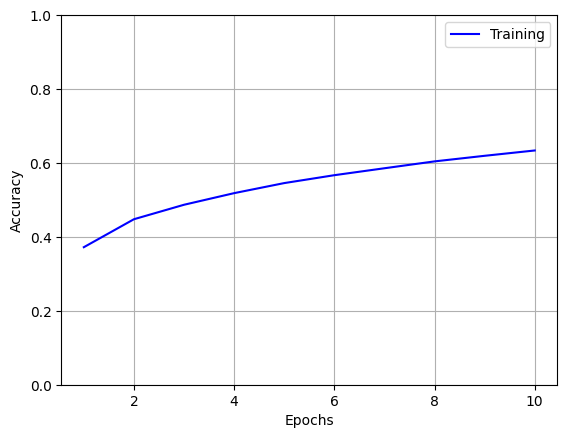

In [25]:
acc = history.history['accuracy']
loss = history.history['loss']
print("Result:")
model.evaluate(X_test,y_test)

plt.plot(np.arange(1, epochs+1), acc, label='Training', color='blue')
plt.grid()
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [ ]:
# Your code